# How to work on Colab
## Email Notification & Session Auto Shutdown

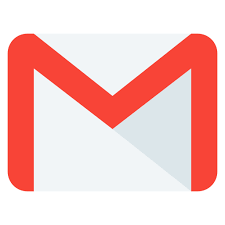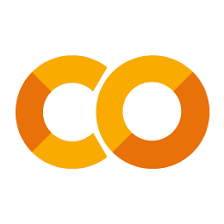

This was supposed to be my baseline to work on [Predict Health Outcomes of Horses (playground-series-s3e22)](https://www.kaggle.com/competitions/playground-series-s3e22) with optuna.<br>
However, I gave too much of `n_trials`, and the Kaggle notebook crashed...<br>
To prevent that to happen again, I decided to move to Colab.<br>

Below is the code to enable email notification & Session Auto Shutdown.<br>
<br>
### Email Notification
You have to search the config for your own email provider.<br>
For gmail users, simply `ctrl` / `cmd` + `f` change `email` to `gmail`.<br><br>
Once you get your App Passwords from<br>`Security` - `2-step verification` setting, enter that password for email_pw,<br> it will work fine for you.<br>
```
import smtplib
from smtplib import SMTPException
from getpass import getpass

email_user = 'your_@email.com'
email_pw = getpass('Enter your Password : ')

mail_from = email_user
mail_to = 'maybe_another_@email.com'

mail_subject = 'TEST'
mail_message_body = 'test_message_body'

mail_message = f'From: {mail_from}\nTo: {mail_to}\nSubject: {mail_subject}\n\n{mail_message_body}'
try:
    server = smtplib.SMTP_SSL('smtp.email.com', 465)
    server.login(email_user, email_pw)
    server.sendmail(mail_from, mail_to, mail_message)
    server.close()
    print("Successfully sent email")
except SMTPException:
    print("Error: unable to send email")
```
<br>

### Session Auto Shutdown:
I believe this is essential for `Pro` & `Pro+` users.<br>
You can place the code below, into `try` & `except` phrase 😊
<br>
```
from google.colab import runtime
runtime.unassign()
```
<br>

Now the baseline starts, you will be able to see the implementations of above functions when you download this and bring it to your colab.

In [1]:
## Use below in Colab
# !pip install -q optuna tensorflow catboost

In [2]:
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")
import logging
logging.disable(logging.ERROR)
import os
os.environ['TRANSFORMERS_NO_ADVISORY_WARNINGS'] = 'true'
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

## Use below in Colab
# import shutil
# from getpass import getpass

import os
import optuna
import pickle
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm.auto import tqdm
from sklearn.svm import SVC
from functools import partial
from sklearn.metrics import auc
from sklearn.impute import KNNImputer
from tensorflow.keras import Sequential
from xgboost.sklearn import XGBClassifier
from lightgbm import LGBMClassifier as lgb
from catboost import CatBoostClassifier as cat
from tensorflow.keras.optimizers import SGD, Adam
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.layers import Input, Dense, ReLU, Softmax, Dropout
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import roc_auc_score, roc_curve, make_scorer, f1_score
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score


In [3]:
## Use below in Colab
'''
secret = getpass('Enter the secret value: ')
os.environ['KAGGLE_USERNAME'] = 'your_kaggle_username'
os.environ['KAGGLE_KEY'] = secret
'''

"\nsecret = getpass('Enter the secret value: ')\nos.environ['KAGGLE_USERNAME'] = 'your_kaggle_username'\nos.environ['KAGGLE_KEY'] = secret\n"

In [4]:
## Use below in Colab
# !kaggle competitions download -c playground-series-s3e22

In [5]:
## Use below in Colab
'''
from zipfile import ZipFile
t = '/content/playground-series-s3e22.zip'

with ZipFile(t, 'r') as Zobject:
    Zobject.extractall(path='/content/')
'''

"\nfrom zipfile import ZipFile\nt = '/content/playground-series-s3e22.zip'\n\nwith ZipFile(t, 'r') as Zobject:\n    Zobject.extractall(path='/content/')\n"

In [6]:
# set configs
is_tuning = True
is_scaling = True
is_pca = False
if is_tuning:
    n_trials=1

# Keras model compile
learning_rate = 1e-3
batch_size = 64
epochs = 20

In [7]:
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    tf.random.set_seed(seed)

seed_everything()

In [8]:
def calculate_f1(y_true, y_pred):
    f1 = f1_score(y_true, y_pred, average='micro')
    return tf.constant(f1, dtype=tf.float32)

In [9]:
train = pd.read_csv('/kaggle/input/playground-series-s3e22/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s3e22/test.csv')
submission = pd.read_csv('/kaggle/input/playground-series-s3e22/sample_submission.csv')

## Use below in Colab
'''
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')
submission = pd.read_csv('/content/sample_submission.csv')
'''

"\ntrain = pd.read_csv('/content/train.csv')\ntest = pd.read_csv('/content/test.csv')\nsubmission = pd.read_csv('/content/sample_submission.csv')\n"

In [10]:
train.head(5)

,id,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,...,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data,outcome
0,0,yes,adult,530001,38.1,132.0,24.0,cool,reduced,dark_cyanotic,...,57.0,8.5,serosanguious,3.4,yes,2209,0,0,no,died
1,1,yes,adult,533836,37.5,88.0,12.0,cool,normal,pale_cyanotic,...,33.0,64.0,serosanguious,2.0,yes,2208,0,0,no,euthanized
2,2,yes,adult,529812,38.3,120.0,28.0,cool,reduced,pale_pink,...,37.0,6.4,serosanguious,3.4,yes,5124,0,0,no,lived
3,3,yes,adult,5262541,37.1,72.0,30.0,cold,reduced,pale_pink,...,53.0,7.0,cloudy,3.9,yes,2208,0,0,yes,lived
4,4,no,adult,5299629,38.0,52.0,48.0,normal,normal,normal_pink,...,47.0,7.3,cloudy,2.6,no,0,0,0,yes,lived


In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1235 entries, 0 to 1234
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     1235 non-null   int64  
 1   surgery                1235 non-null   object 
 2   age                    1235 non-null   object 
 3   hospital_number        1235 non-null   int64  
 4   rectal_temp            1235 non-null   float64
 5   pulse                  1235 non-null   float64
 6   respiratory_rate       1235 non-null   float64
 7   temp_of_extremities    1196 non-null   object 
 8   peripheral_pulse       1175 non-null   object 
 9   mucous_membrane        1214 non-null   object 
 10  capillary_refill_time  1229 non-null   object 
 11  pain                   1191 non-null   object 
 12  peristalsis            1215 non-null   object 
 13  abdominal_distention   1212 non-null   object 
 14  nasogastric_tube       1155 non-null   object 
 15  naso

In [12]:
mapping = {'yes' : 0, 'no' : 1}
train.surgery = train.surgery.map(mapping)
test.surgery = test.surgery.map(mapping)
train.surgical_lesion = train.surgical_lesion.map(mapping)
test.surgical_lesion = test.surgical_lesion.map(mapping)
train.cp_data = train.cp_data.map(mapping)
test.cp_data = test.cp_data.map(mapping)
mapping = {'adult' : 1, 'young' : 0}
train.age = train.age.map(mapping)
test.age = test.age.map(mapping)
mapping = {'cool' : 0, 'cold' : 1, 'normal' : 2, 'warm' : 3}
train.temp_of_extremities = train.temp_of_extremities.map(mapping)
test.temp_of_extremities = test.temp_of_extremities.map(mapping)
mapping = {'absent' : 0, 'reduced' : 1, 'normal' : 2, 'increased' : 3}
train.peripheral_pulse = train.peripheral_pulse.map(mapping)
test.peripheral_pulse = test.peripheral_pulse.map(mapping)
mapping = {'dark_cyanotic' : 0, 'pale_cyanotic' : 1, 'pale_pink' : 2, 'normal_pink' : 3, 'bright_pink' : 4, 'bright_red' : 5}
train.mucous_membrane = train.mucous_membrane.map(mapping)
test.mucous_membrane = test.mucous_membrane.map(mapping)
mapping = {'less_3_sec' : 0, 'more_3_sec' : 1, '3' : 3}
train.capillary_refill_time = train.capillary_refill_time.map(mapping)
test.capillary_refill_time = test.capillary_refill_time.map(mapping)
mapping = {'depressed' : 0, 'mild_pain' : 1, 'extreme_pain' : 2, 'alert': 3, 'severe_pain' : 4, 'slight' : 5}
train.pain = train.pain.map(mapping)
test.pain = test.pain.map(mapping)
mapping = {'absent' : 0, 'hypomotile' : 1, 'normal' : 2, 'hypermotile': 3, 'distend_small' : 4}
train.peristalsis = train.peristalsis.map(mapping)
test.peristalsis = test.peristalsis.map(mapping)
mapping = {'slight' : 0, 'moderate' : 1, 'none' : 2, 'severe': 3}
train.abdominal_distention = train.abdominal_distention.map(mapping)
test.abdominal_distention = test.abdominal_distention.map(mapping)
mapping = {'slight' : 0, 'significant' : 1, 'none' : 2}
train.nasogastric_tube = train.nasogastric_tube.map(mapping)
test.nasogastric_tube = test.nasogastric_tube.map(mapping)
mapping = {'less_1_liter' : 0, 'more_1_liter' : 1, 'none' : 2, 'slight' : 3}
train.nasogastric_reflux = train.nasogastric_reflux.map(mapping)
test.nasogastric_reflux = test.nasogastric_reflux.map(mapping)
mapping = {'decreased' : 0, 'absent' : 1, 'normal' : 2, 'increased' : 3, 'serosanguious' : 4}
train.rectal_exam_feces = train.rectal_exam_feces.map(mapping)
test.rectal_exam_feces = test.rectal_exam_feces.map(mapping)
mapping = {'distend_small' : 0, 'distend_large' : 1, 'normal' : 2, 'firm' : 3, 'other' : 4}
train.abdomen = train.abdomen.map(mapping)
test.abdomen = test.abdomen.map(mapping)
mapping = {'serosanguious' : 0, 'cloudy' : 1, 'clear' : 2}
train.abdomo_appearance = train.abdomo_appearance.map(mapping)
test.abdomo_appearance = test.abdomo_appearance.map(mapping)
mapping = {'lived' : 0, 'died' : 1, 'euthanized': 2}
train.outcome = train.outcome.map(mapping)

In [13]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1235 entries, 0 to 1234
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     1235 non-null   int64  
 1   surgery                1235 non-null   int64  
 2   age                    1235 non-null   int64  
 3   hospital_number        1235 non-null   int64  
 4   rectal_temp            1235 non-null   float64
 5   pulse                  1235 non-null   float64
 6   respiratory_rate       1235 non-null   float64
 7   temp_of_extremities    1196 non-null   float64
 8   peripheral_pulse       1175 non-null   float64
 9   mucous_membrane        1214 non-null   float64
 10  capillary_refill_time  1229 non-null   float64
 11  pain                   1191 non-null   float64
 12  peristalsis            1215 non-null   float64
 13  abdominal_distention   1212 non-null   float64
 14  nasogastric_tube       1155 non-null   float64
 15  naso

In [14]:
train.describe()

,id,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,...,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data,outcome
count,1235.0000,1235.000000,1235.000000,1.235000e+03,1235.000000,1235.000000,1235.000000,1196.000000,1175.000000,1214.000000,...,1235.000000,1235.000000,1187.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000
mean,617.0000,0.281781,0.939271,9.545004e+05,38.202186,79.574089,30.054251,0.770903,1.356596,2.475288,...,49.602429,21.388016,0.737152,3.290931,0.247773,3832.496356,14.612146,3.577328,0.459109,0.738462
std,356.6581,0.450050,0.238929,1.356403e+06,0.788668,29.108638,16.452066,0.987464,0.516826,1.564960,...,10.535800,26.676453,0.793094,1.589195,0.431894,5436.733774,193.705735,88.858953,0.498527,0.774661
min,0.0000,0.000000,0.000000,5.213990e+05,35.400000,30.000000,8.000000,0.000000,0.000000,0.000000,...,23.000000,3.500000,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,308.5000,0.000000,1.000000,5.288000e+05,37.800000,53.000000,18.000000,0.000000,1.000000,1.000000,...,43.000000,6.600000,0.000000,2.000000,0.000000,2205.000000,0.000000,0.000000,0.000000,0.000000
50%,617.0000,0.000000,1.000000,5.297770e+05,38.200000,76.000000,28.000000,0.000000,1.000000,2.000000,...,48.000000,7.500000,1.000000,3.000000,0.000000,2209.000000,0.000000,0.000000,0.000000,1.000000
75%,925.5000,1.000000,1.000000,5.341450e+05,38.600000,100.000000,36.000000,2.000000,2.000000,3.000000,...,57.000000,9.100000,1.000000,4.300000,0.000000,3205.000000,0.000000,0.000000,1.000000,1.000000
max,1234.0000,1.000000,1.000000,5.305129e+06,40.800000,184.000000,96.000000,3.000000,3.000000,5.000000,...,75.000000,89.000000,2.000000,10.100000,1.000000,41110.000000,3112.000000,2209.000000,1.000000,2.000000


In [15]:
imputer =  KNNImputer(n_neighbors=3,)
tr_columns = list(train.columns)
te_columns = list(test.columns)
train[tr_columns] = imputer.fit_transform(train[tr_columns])
test[te_columns] = imputer.fit_transform(test[te_columns])

In [16]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1235 entries, 0 to 1234
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     1235 non-null   float64
 1   surgery                1235 non-null   float64
 2   age                    1235 non-null   float64
 3   hospital_number        1235 non-null   float64
 4   rectal_temp            1235 non-null   float64
 5   pulse                  1235 non-null   float64
 6   respiratory_rate       1235 non-null   float64
 7   temp_of_extremities    1235 non-null   float64
 8   peripheral_pulse       1235 non-null   float64
 9   mucous_membrane        1235 non-null   float64
 10  capillary_refill_time  1235 non-null   float64
 11  pain                   1235 non-null   float64
 12  peristalsis            1235 non-null   float64
 13  abdominal_distention   1235 non-null   float64
 14  nasogastric_tube       1235 non-null   float64
 15  naso

In [17]:
[variance_inflation_factor(train, i) for i in range (train.shape[1])]


[4.1073550030007135,
 2.138448501878949,
 19.321764137144374,
 1.6349520651926368,
 112.47517384293073,
 17.393664115315744,
 5.425299956358476,
 2.3172880764225137,
 14.411550654725982,
 4.420279574200808,
 2.1172141363893515,
 2.1467028479068184,
 3.3198106716847637,
 2.804563038361543,
 1.6455688232983743,
 3.496362457161719,
 11.023121844179625,
 3.1900864518303096,
 2.466265981172211,
 36.72102688436795,
 3.141441717426641,
 2.81271776279272,
 7.669245604416013,
 2.2223306901003967,
 1.6001029082753033,
 1.7716805335633306,
 1.7427767496211881,
 2.479962662413029,
 2.5722560168450257]

In [18]:
def check_vif(df):
    vifs = [variance_inflation_factor(df, i) for i in range(df.shape[1])]
    vif_df = pd.DataFrame({"features":df.columns, "VIF" : vifs})
    vif_df = vif_df.sort_values(by="VIF", ascending=False)
    remove_col = vif_df.iloc[0, 0]
    top_vif = vif_df.iloc[0, 1]
    return vif_df, remove_col, top_vif

In [19]:
top_vif = 100

while(top_vif > 5):
    vif_df, remove_col, top_vif = check_vif(train)
    print(remove_col, top_vif)
    if top_vif < 5:
        break
    train = train.drop(columns=remove_col)

train

rectal_temp 112.47517384293073
packed_cell_volume 29.90095536463861
age 12.482531626339773
pulse 12.302053640157709
peripheral_pulse 11.566121925292439
nasogastric_reflux_ph 8.671301679003673
abdomo_protein 5.5139227106207604
mucous_membrane 4.037298104590689


,id,surgery,hospital_number,respiratory_rate,temp_of_extremities,mucous_membrane,capillary_refill_time,pain,peristalsis,abdominal_distention,...,rectal_exam_feces,abdomen,total_protein,abdomo_appearance,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data,outcome
0,0.0,0.0,530001.0,24.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.000000,0.0,8.5,0.0,0.0,2209.0,0.0,0.0,1.0,1.0
1,1.0,0.0,533836.0,12.0,0.0,1.0,1.0,1.0,0.0,1.0,...,1.000000,0.0,64.0,0.0,0.0,2208.0,0.0,0.0,1.0,2.0
2,2.0,0.0,529812.0,28.0,0.0,2.0,0.0,2.0,1.0,1.0,...,1.000000,1.0,6.4,0.0,0.0,5124.0,0.0,0.0,1.0,0.0
3,3.0,0.0,5262541.0,30.0,1.0,2.0,1.0,1.0,1.0,1.0,...,0.000000,0.0,7.0,1.0,0.0,2208.0,0.0,0.0,0.0,0.0
4,4.0,1.0,5299629.0,48.0,2.0,3.0,0.0,3.0,1.0,2.0,...,2.000000,2.0,7.3,1.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1230,1230.0,0.0,535246.0,48.0,0.0,2.0,1.0,0.0,0.0,1.0,...,0.666667,1.0,66.0,0.0,0.0,2206.0,0.0,0.0,1.0,0.0
1231,1231.0,0.0,528570.0,50.0,0.0,1.0,0.0,1.0,1.0,0.0,...,0.000000,0.0,6.4,0.0,0.0,2209.0,0.0,0.0,0.0,1.0
1232,1232.0,0.0,529685.0,40.0,2.0,3.0,0.0,1.0,1.0,0.0,...,3.000000,3.0,5.9,1.0,0.0,400.0,0.0,0.0,0.0,0.0
1233,1233.0,0.0,534784.0,16.0,2.0,5.0,0.0,1.0,1.0,0.0,...,1.000000,0.0,74.0,1.0,0.0,2209.0,0.0,0.0,1.0,0.0


<Axes: >

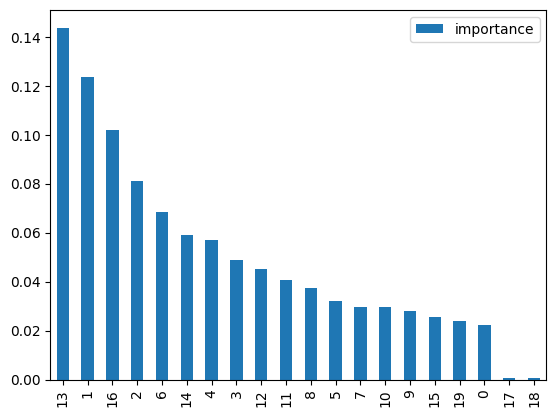

In [20]:
X = train.drop(columns=['outcome', 'id'])
y = train['outcome']

rf = RandomForestClassifier()
rf.fit(X, y)
# [(col, fi) for col, fi in zip(X.columns, rf.feature_importances_)]
fi_df = pd.DataFrame({'feature': X.columns, 'importance' : rf.feature_importances_})

fi_df.sort_values(by='importance', ascending=False).plot(kind='bar')

In [21]:
selected_cols = fi_df.sort_values(by='importance', ascending=False)[:10]['feature'].values
selected_cols

array(['total_protein', 'hospital_number', 'lesion_1', 'respiratory_rate',
       'pain', 'abdomo_appearance', 'mucous_membrane',
       'temp_of_extremities', 'abdomen', 'rectal_exam_feces'],
      dtype=object)

In [22]:
# class imbalance handling

## 1. undersampling
c0 = train[train.outcome==0]
c1 = train[train.outcome==1]
c2 = train[train.outcome==2]

print(c0.shape, c1.shape, c2.shape)
# c0 = c0.sample(n=c1.shape[0])
# train = pd.concat([c0, c1])
# train.shape

(574, 22) (410, 22) (251, 22)


In [23]:
from imblearn.over_sampling import SMOTE

X = train[selected_cols]
y = train['outcome']

smote = SMOTE(k_neighbors=5)
X_resampled, y_resampled = smote.fit_resample(X, y)
print(X_resampled.shape, y_resampled.shape)

(1722, 10) (1722,)


In [24]:
X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, test_size=0.15, stratify=y_resampled, random_state=42)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)


(1463, 10) (259, 10) (1463,) (259,)


In [25]:
from sklearn.preprocessing import StandardScaler

if is_scaling:
    scaler = StandardScaler()
    data_ = scaler.fit_transform(X_train)
    X_train = pd.DataFrame(data=data_, columns=X_train.columns)
    data_ = scaler.transform(X_val)
    X_val = pd.DataFrame(data=data_, columns=X_val.columns)
    display(X_train)

,total_protein,hospital_number,lesion_1,respiratory_rate,pain,abdomo_appearance,mucous_membrane,temp_of_extremities,abdomen,rectal_exam_feces
0,-0.593239,-0.308563,-0.737374,-0.182586,1.305084,0.467881,0.407235,1.501310,2.423875,1.337503
1,-0.603869,-0.308241,5.295398,0.701236,-0.981831,0.467881,-0.919924,-0.734212,1.330465,-1.429371
2,-0.610956,-0.308052,-0.737374,-0.182586,-0.219526,1.830208,0.407235,1.501310,2.059405,1.337503
3,-0.575523,-0.308608,-0.115869,-0.056325,-0.981831,1.830208,-0.919924,-0.734212,0.237054,-0.045934
4,2.046536,-0.304406,-0.309010,1.080017,-0.981831,0.467881,-0.919924,0.383549,-0.491886,-0.507080
...,...,...,...,...,...,...,...,...,...,...
1458,-0.628672,-0.308708,-0.325493,-0.940148,-0.219526,1.830208,1.734394,-0.734212,0.237054,2.720940
1459,2.037920,-0.304030,-0.465890,0.383861,-0.611088,-0.231886,-1.081288,-0.734212,0.237054,-1.092958
1460,-0.593239,-0.307843,0.232213,0.574976,-0.219526,0.467881,-0.256344,1.501310,2.423875,1.337503
1461,-0.575523,-0.308421,-0.134097,0.322455,-0.981831,-0.894446,1.734394,-0.734212,0.237054,-0.045934


In [26]:
if is_pca:
    from sklearn.decomposition import PCA

    pca = PCA(n_components=0.90, random_state=42)
    data_ = pca.fit_transform(X_train)
    X_train = pd.DataFrame(data=data_, columns=[f"PC{i}" for i in range(1, data_.shape[1]+1)])
    data_ = pca.transform(X_val)
    X_val = pd.DataFrame(data=data_, columns=[f"PC{i}" for i in range(1, data_.shape[1]+1)])

    display(X_train)

In [27]:
svm = SVC(random_state=42)
lr = LogisticRegression(multi_class='multinomial', random_state=42, max_iter=300)
xgb = XGBClassifier(max_depth=3, colsample_bytree=0.8, reg_lambda=1, objective='multi:softmax', num_class=3, random_state=42)
rf = RandomForestClassifier(max_depth=3, max_features=0.8, criterion='gini', random_state=42)
catb = cat(iterations=300, depth=3, od_type='Iter', od_wait=15, bootstrap_type='Bayesian', random_state=42)
lgbm = lgb(boosting_type='gbdt', min_child_samples=20, min_child_weight=0.001, n_estimators=20, random_state=42)

nn = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(20), ReLU(), Dropout(0.2),
    Dense(20), ReLU(), Dropout(0.2),
    Dense(10), ReLU(), Dropout(0.1),
    Dense(20), ReLU(), Dropout(0.2),
    Dense(20), ReLU(), Dropout(0.2),
    Dense(3), Softmax()
])
nn.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                220       
                                                                 
 re_lu (ReLU)                (None, 20)                0         
                                                                 
 dropout (Dropout)           (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 20)                420       
                                                                 
 re_lu_1 (ReLU)              (None, 20)                0         
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_2 (Dense)             (None, 10)                2

In [28]:
optimizer = Adam(learning_rate=learning_rate)
loss_fn = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.8)   # [0.8, 0.2] <--> [0.9, 0] // [0, 0.9]
scheduler = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.5,
                              patience=10,
                              min_lr=1e-6)
earlystopper = EarlyStopping(monitor='val_loss',
                             patience=20,
                             min_delta=1e-2)


nn.compile(optimizer=optimizer, loss=loss_fn, metrics=[calculate_f1])

nn_y_train = tf.keras.utils.to_categorical(y_train, num_classes=3)
nn_y_val = tf.keras.utils.to_categorical(y_val, num_classes=3)

In [29]:
print("\nFitting LogisticRegression...")
lr.fit(X_train, y_train)
print("\nFitting SVM...")
svm.fit(X_train, y_train)
print("\nFitting RandomForest...")
rf.fit(X_train, y_train)
print("\nFitting XGBoost...")
xgb.fit(X_train, y_train)
print("\nFitting CatBoost...")
catb.fit(X_train, y_train)
print("\nFitting Light GBM...")
lgbm.fit(X_train, y_train)
# print("\nFitting MLP...")
# history = nn.fit(X_train, nn_y_train,
#                 batch_size=batch_size,
#                 epochs=epochs,
#                 validation_data=[X_val, nn_y_val],
#                 callbacks=[scheduler, earlystopper])



Fitting LogisticRegression...

Fitting SVM...

Fitting RandomForest...

Fitting XGBoost...

Fitting CatBoost...
Learning rate set to 0.223143
0:	learn: 1.0135371	total: 56ms	remaining: 16.8s
1:	learn: 0.9481199	total: 57.6ms	remaining: 8.58s
2:	learn: 0.9107264	total: 59.1ms	remaining: 5.85s
3:	learn: 0.8804978	total: 60.5ms	remaining: 4.47s
4:	learn: 0.8636394	total: 61.8ms	remaining: 3.65s
5:	learn: 0.8447333	total: 63ms	remaining: 3.08s
6:	learn: 0.8255463	total: 64.1ms	remaining: 2.68s
7:	learn: 0.8119520	total: 65.2ms	remaining: 2.38s
8:	learn: 0.7949491	total: 66.3ms	remaining: 2.14s
9:	learn: 0.7815603	total: 67.4ms	remaining: 1.96s
10:	learn: 0.7682546	total: 68.6ms	remaining: 1.8s
11:	learn: 0.7603655	total: 69.9ms	remaining: 1.68s
12:	learn: 0.7561771	total: 71ms	remaining: 1.57s
13:	learn: 0.7498425	total: 72.1ms	remaining: 1.47s
14:	learn: 0.7424006	total: 73.2ms	remaining: 1.39s
15:	learn: 0.7359106	total: 74.3ms	remaining: 1.32s
16:	learn: 0.7307284	total: 75.6ms	remaini

LGBMClassifier(n_estimators=20, random_state=42)

In [30]:
evaluation_metric = calculate_f1

In [31]:
print("--- Prediction with LR ---")
lr_pred_train = lr.predict(X_train)
lr_pred_val = lr.predict(X_val)

lr_train_score = evaluation_metric(y_train, lr_pred_train)
lr_val_score = evaluation_metric(y_val, lr_pred_val)

print("Train Score : %.4f" % lr_train_score)
print("Test Score : %.4f" % lr_val_score)

print("--- Prediction with SVM ---")
svm_pred_train = svm.predict(X_train)
svm_pred_val = svm.predict(X_val)

svm_train_score = evaluation_metric(y_train, svm_pred_train)
svm_val_score = evaluation_metric(y_val, svm_pred_val)

print("Train Score : %.4f" % svm_train_score)
print("Test Score : %.4f" % svm_val_score)

print("--- Prediction with RF ---")
rf_pred_train = rf.predict(X_train)
rf_pred_val = rf.predict(X_val)

rf_train_score = evaluation_metric(y_train, rf_pred_train)
rf_val_score = evaluation_metric(y_val, rf_pred_val)

print("Train Score : %.4f" % rf_train_score)
print("Test Score : %.4f" % rf_val_score)

print("--- Prediction with CAT ---")
cat_pred_train = catb.predict(X_train)
cat_pred_val = catb.predict(X_val)

cat_train_score = evaluation_metric(y_train, cat_pred_train)
cat_val_score = evaluation_metric(y_val, cat_pred_val)

print("Train Score : %.4f" % cat_train_score)
print("Test Score : %.4f" % cat_val_score)

print("--- Prediction with LGBM ---")
lgb_pred_train = lgbm.predict(X_train)
lgb_pred_val = lgbm.predict(X_val)

lgb_train_score = evaluation_metric(y_train, lgb_pred_train)
lgb_val_score = evaluation_metric(y_val, lgb_pred_val)

print("Train Score : %.4f" % lgb_train_score)
print("Test Score : %.4f" % lgb_val_score)

--- Prediction with LR ---
Train Score : 0.6254
Test Score : 0.6448
--- Prediction with SVM ---
Train Score : 0.7211
Test Score : 0.6680
--- Prediction with RF ---
Train Score : 0.6671
Test Score : 0.6718
--- Prediction with CAT ---
Train Score : 0.8865
Test Score : 0.7568
--- Prediction with LGBM ---
Train Score : 0.8913
Test Score : 0.7683


In [32]:
'''
import smtplib
from smtplib import SMTPException
from getpass import getpass

email_user = 'your_@email.com'
email_pw = getpass('Enter your Password :')

mail_from = email_user
mail_to = 'maybe_another_@email.com'

mail_subject = 'TEST'
mail_message_body = 'test_message_body'

mail_message = f'From: {mail_from}\nTo: {mail_to}\nSubject: {mail_subject}\n\n{mail_message_body}'
try:
    server = smtplib.SMTP_SSL('smtp.email.com', 465)
    server.login(email_user, email_pw)
    server.sendmail(mail_from, mail_to, mail_message)
    server.close()
    print("Successfully sent email")
except SMTPException:
    print("Error: unable to send email")
'''

'\nimport smtplib\nfrom smtplib import SMTPException\nfrom getpass import getpass\n\nemail_user = \'your_@email.com\'\nemail_pw = getpass(\'Enter your Password :\')\n\nmail_from = email_user\nmail_to = \'maybe_another_@email.com\'\n\nmail_subject = \'TEST\'\nmail_message_body = \'test_message_body\'\n\nmail_message = f\'From: {mail_from}\nTo: {mail_to}\nSubject: {mail_subject}\n\n{mail_message_body}\'\ntry:\n    server = smtplib.SMTP_SSL(\'smtp.email.com\', 465)\n    server.login(email_user, email_pw)\n    server.sendmail(mail_from, mail_to, mail_message)\n    server.close()\n    print("Successfully sent email")\nexcept SMTPException:\n    print("Error: unable to send email")\n'

In [33]:
'''
def lr_optimizer(trial, X, y, K):

    C = trial.suggest_int('C', 5, 100)
    solver = trial.suggest_categorical('solver', ['newton-cg', 'sag', 'lbfgs', 'saga'])


    model = LogisticRegression(C=C,
                               solver=solver,
                               max_iter=500,
                               multi_class='multinomial',
                               class_weight='balanced',
                               random_state=42,
                               n_jobs=-1)


    kf = StratifiedKFold(n_splits=K, shuffle=True, random_state=42)
    f1_scores = []

    for train_idx, val_idx in kf.split(X, y):
        X_train = X.iloc[train_idx, :]
        y_train = y.iloc[train_idx]

        X_val = X.iloc[val_idx, :]
        y_val = y.iloc[val_idx]

        model.fit(X_train, y_train)
        preds = model.predict(X_val)
        f1 = f1_score(y_val, preds, average='micro')
        f1_scores.append(f1)


    return -np.mean(f1_scores)
'''

"\ndef lr_optimizer(trial, X, y, K):\n\n    C = trial.suggest_int('C', 5, 100)\n    solver = trial.suggest_categorical('solver', ['newton-cg', 'sag', 'lbfgs', 'saga'])\n\n\n    model = LogisticRegression(C=C,\n                               solver=solver,\n                               max_iter=500,\n                               multi_class='multinomial',\n                               class_weight='balanced',\n                               random_state=42,\n                               n_jobs=-1)\n\n\n    kf = StratifiedKFold(n_splits=K, shuffle=True, random_state=42)\n    f1_scores = []\n\n    for train_idx, val_idx in kf.split(X, y):\n        X_train = X.iloc[train_idx, :]\n        y_train = y.iloc[train_idx]\n\n        X_val = X.iloc[val_idx, :]\n        y_val = y.iloc[val_idx]\n\n        model.fit(X_train, y_train)\n        preds = model.predict(X_val)\n        f1 = f1_score(y_val, preds, average='micro')\n        f1_scores.append(f1)\n\n\n    return -np.mean(f1_scores)\n"

In [34]:
'''
%%time
try:
    K = 6 # set K of K-Fold
    opt_func = partial(lr_optimizer, X=X_train, y=y_train, K=K)

    if is_tuning:
        lr_study = optuna.create_study(direction="maximize") # determine minimize or maximize sth
        lr_study.optimize(opt_func, n_trials=n_trials)
        mail_subject = 'Logistic Regression Finished'
        mail_message_body = 'Logistic Regression Finished.\
        Starting Random Forest.'

        mail_message = f'From: {mail_from}\nTo: {mail_to}\nSubject: {mail_subject}\n\n{mail_message_body}'

        try:
            server = smtplib.SMTP_SSL('smtp.email.com', 465)
            server.login(email_user, email_pw)
            server.sendmail(mail_from, mail_to, msg=mail_message)
            server.close()
            print("Successfully sent email")
        except SMTPException:
            print("Error: unable to send email")
except:
    mail_subject = 'Logistic Regression Failed'
    mail_message_body = 'Logistic Regression Failed.\
    Shutting Colab off.'

    mail_message = f'From: {mail_from}\nTo: {mail_to}\nSubject: {mail_subject}\n\n{mail_message_body}'

    try:
        server = smtplib.SMTP_SSL('smtp.email.com', 465)
        server.login(email_user, email_pw)
        server.sendmail(mail_from, mail_to, mail_message)
        server.close()
        print("Successfully sent email")
    except SMTPException:
        print("Error: unable to send email")

    from google.colab import runtime
    runtime.unassign()
'''

'\n%%time\ntry:\n    K = 6 # set K of K-Fold\n    opt_func = partial(lr_optimizer, X=X_train, y=y_train, K=K)\n\n    if is_tuning:\n        lr_study = optuna.create_study(direction="maximize") # determine minimize or maximize sth\n        lr_study.optimize(opt_func, n_trials=n_trials)\n        mail_subject = \'Logistic Regression Finished\'\n        mail_message_body = \'Logistic Regression Finished.        Starting Random Forest.\'\n\n        mail_message = f\'From: {mail_from}\nTo: {mail_to}\nSubject: {mail_subject}\n\n{mail_message_body}\'\n\n        try:\n            server = smtplib.SMTP_SSL(\'smtp.email.com\', 465)\n            server.login(email_user, email_pw)\n            server.sendmail(mail_from, mail_to, msg=mail_message)\n            server.close()\n            print("Successfully sent email")\n        except SMTPException:\n            print("Error: unable to send email")\nexcept:\n    mail_subject = \'Logistic Regression Failed\'\n    mail_message_body = \'Logistic Regre

In [35]:
'''
def rf_optimizer(trial, X, y, K):
    # define parameter to tune
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    max_depth = trial.suggest_int('max_depth', 4, 20)
    max_features = trial.suggest_float('max_features', 0.6, 0.8, log=True)

    model = RandomForestClassifier(n_estimators=n_estimators,
                                       max_depth=max_depth,
                                       max_features=max_features,
                                       criterion='gini',
                                       class_weight='balanced',
                                       random_state=42
                                      )
    kf = StratifiedKFold(n_splits=K, shuffle=True, random_state=42)
    f1_scores = []

    for train_idx, val_idx in kf.split(X, y):
        X_train, X_val = X.iloc[train_idx, :], X.iloc[val_idx, :]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model.fit(X_train, y_train)
        preds = model.predict(X_val)
        f1 = f1_score(y_val, preds, average='micro')
        f1_scores.append(f1)
#         print(f1)

    return -np.mean(f1_scores)
'''

"\ndef rf_optimizer(trial, X, y, K):\n    # define parameter to tune\n    n_estimators = trial.suggest_int('n_estimators', 50, 500)\n    max_depth = trial.suggest_int('max_depth', 4, 20)\n    max_features = trial.suggest_float('max_features', 0.6, 0.8, log=True)\n\n    model = RandomForestClassifier(n_estimators=n_estimators,\n                                       max_depth=max_depth,\n                                       max_features=max_features,\n                                       criterion='gini',\n                                       class_weight='balanced',\n                                       random_state=42\n                                      )\n    kf = StratifiedKFold(n_splits=K, shuffle=True, random_state=42)\n    f1_scores = []\n\n    for train_idx, val_idx in kf.split(X, y):\n        X_train, X_val = X.iloc[train_idx, :], X.iloc[val_idx, :]\n        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]\n\n        model.fit(X_train, y_train)\n        preds = mo

In [36]:
'''
%%time

K = 6 # set K of K-Fold
opt_func = partial(rf_optimizer, X=X_train, y=y_train, K=K)
try:
    if is_tuning:
        rf_study = optuna.create_study(direction="maximize") # determine minimize or maximize sth
        rf_study.optimize(opt_func, n_trials=n_trials)
        mail_subject = 'Random Forest Finished'
        mail_message_body = 'Random Forest Finished.\
        Starting Support Vector Machine.'
        
        mail_message = f'From: {mail_from}\nTo: {mail_to}\nSubject: {mail_subject}\n\n{mail_message_body}'
        
        try:
            server = smtplib.SMTP_SSL('smtp.email.com', 465)
            server.login(email_user, email_pw)
            server.sendmail(mail_from, mail_to, mail_message)
            server.close()
            print("Successfully sent email")
        except SMTPException:
            print("Error: unable to send email")
except:
    mail_subject = 'Random Forest Failed'
    mail_message_body = 'Random Forest Failed.\
    Shutting Colab off.'

    mail_message = f'From: {mail_from}\nTo: {mail_to}\nSubject: {mail_subject}\n\n{mail_message_body}'

    try:
        server = smtplib.SMTP_SSL('smtp.email.com', 465)
        server.login(email_user, email_pw)
        server.sendmail(mail_from, mail_to, mail_message)
        server.close()
        print("Successfully sent email")
    except SMTPException:
        print("Error: unable to send email")

    from google.colab import runtime
    runtime.unassign()
'''

'\n%%time\n\nK = 6 # set K of K-Fold\nopt_func = partial(rf_optimizer, X=X_train, y=y_train, K=K)\ntry:\n    if is_tuning:\n        rf_study = optuna.create_study(direction="maximize") # determine minimize or maximize sth\n        rf_study.optimize(opt_func, n_trials=n_trials)\n        mail_subject = \'Random Forest Finished\'\n        mail_message_body = \'Random Forest Finished.        Starting Support Vector Machine.\'\n        \n        mail_message = f\'From: {mail_from}\nTo: {mail_to}\nSubject: {mail_subject}\n\n{mail_message_body}\'\n        \n        try:\n            server = smtplib.SMTP_SSL(\'smtp.email.com\', 465)\n            server.login(email_user, email_pw)\n            server.sendmail(mail_from, mail_to, mail_message)\n            server.close()\n            print("Successfully sent email")\n        except SMTPException:\n            print("Error: unable to send email")\nexcept:\n    mail_subject = \'Random Forest Failed\'\n    mail_message_body = \'Random Forest Faile

In [37]:
'''
def svm_optimizer(trial, X, y, K):
    C = trial.suggest_int('C', 1, 100)

    model = SVC(C=C,
                kernel='rbf',
                class_weight='balanced', # if class imbalanced
                gamma='auto',
                decision_function_shape='ovo',
                probability=True,
                cache_size=1000,
                random_state=42
               )

    kf = StratifiedKFold(n_splits=K, shuffle=True, random_state=42)
    f1_scores = []

    for train_idx, val_idx in kf.split(X, y):
        X_train = X.iloc[train_idx, :]
        y_train = y.iloc[train_idx]

        X_val = X.iloc[val_idx, :]
        y_val = y.iloc[val_idx]

        model.fit(X_train, y_train)
        preds = model.predict(X_val)
        f1 = f1_score(y_val, preds, average='micro')
        f1_scores.append(f1)


    return -np.mean(f1_scores)
'''

"\ndef svm_optimizer(trial, X, y, K):\n    C = trial.suggest_int('C', 1, 100)\n\n    model = SVC(C=C,\n                kernel='rbf',\n                class_weight='balanced', # if class imbalanced\n                gamma='auto',\n                decision_function_shape='ovo',\n                probability=True,\n                cache_size=1000,\n                random_state=42\n               )\n\n    kf = StratifiedKFold(n_splits=K, shuffle=True, random_state=42)\n    f1_scores = []\n\n    for train_idx, val_idx in kf.split(X, y):\n        X_train = X.iloc[train_idx, :]\n        y_train = y.iloc[train_idx]\n\n        X_val = X.iloc[val_idx, :]\n        y_val = y.iloc[val_idx]\n\n        model.fit(X_train, y_train)\n        preds = model.predict(X_val)\n        f1 = f1_score(y_val, preds, average='micro')\n        f1_scores.append(f1)\n\n\n    return -np.mean(f1_scores)\n"

In [38]:
'''
%%time

K = 6
opt_func = partial(svm_optimizer, X=X_train, y=y_train, K=K)

try:
    if is_tuning:
        svm_study = optuna.create_study(direction="maximize")
        svm_study.optimize(opt_func, n_trials=n_trials)
        mail_subject = 'Support Vector Machine Finished'
        mail_message_body = 'Support Vector Machine Finished.\
        Starting XG Boost.'

        mail_message = f'From: {mail_from}\nTo: {mail_to}\nSubject: {mail_subject}\n\n{mail_message_body}'

        try:
            server = smtplib.SMTP_SSL('smtp.email.com', 465)
            server.login(email_user, email_pw)
            server.sendmail(mail_from, mail_to, mail_message)
            server.close()
            print("Successfully sent email")
        except SMTPException:
            print("Error: unable to send email")
except:
    mail_subject = 'Support Vector Machine Failed'
    mail_message_body = 'Support Vector Machine Failed.\
    Shutting Colab off.'

    mail_message = f'From: {mail_from}\nTo: {mail_to}\nSubject: {mail_subject}\n\n{mail_message_body}'

    try:
        server = smtplib.SMTP_SSL('smtp.email.com', 465)
        server.login(email_user, email_pw)
        server.sendmail(mail_from, mail_to, mail_message)
        server.close()
        print("Successfully sent email")
    except SMTPException:
        print("Error: unable to send email")

    from google.colab import runtime
    runtime.unassign()
'''

'\n%%time\n\nK = 6\nopt_func = partial(svm_optimizer, X=X_train, y=y_train, K=K)\n\ntry:\n    if is_tuning:\n        svm_study = optuna.create_study(direction="maximize")\n        svm_study.optimize(opt_func, n_trials=n_trials)\n        mail_subject = \'Support Vector Machine Finished\'\n        mail_message_body = \'Support Vector Machine Finished.        Starting XG Boost.\'\n\n        mail_message = f\'From: {mail_from}\nTo: {mail_to}\nSubject: {mail_subject}\n\n{mail_message_body}\'\n\n        try:\n            server = smtplib.SMTP_SSL(\'smtp.email.com\', 465)\n            server.login(email_user, email_pw)\n            server.sendmail(mail_from, mail_to, mail_message)\n            server.close()\n            print("Successfully sent email")\n        except SMTPException:\n            print("Error: unable to send email")\nexcept:\n    mail_subject = \'Support Vector Machine Failed\'\n    mail_message_body = \'Support Vector Machine Failed.    Shutting Colab off.\'\n\n    mail_mess

In [39]:
'''
def xgb_optimizer(trial, X, y, K):
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    max_depth = trial.suggest_int('max_depth', 4, 20)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 0.8, log=True)
    learning_rate = trial.suggest_float('learning_rate', 1e-3, 1e-2, log=True)
    num_class = trial.suggest_int('num_class', 2, 10)
    reg_lambda = trial.suggest_float('reg_lambda', 0.1, 2, log=True)
    booster = trial.suggest_categorical('booster', ['gbtree', 'dart'])


    model = XGBClassifier(objective='multi:softmax',
                          n_estimators=n_estimators,
                          max_depth=max_depth,
                          colsample_bytree=colsample_bytree,
                          num_class=num_class,
                          eta=learning_rate,
                          reg_lambda=reg_lambda,
                          random_state=42
                         )


    kf = StratifiedKFold(n_splits=K, shuffle=True, random_state=42)
    f1_scores = []

    for train_idx, val_idx in kf.split(X, y):
        X_train = X.iloc[train_idx, :]
        y_train = y.iloc[train_idx]

        X_val = X.iloc[val_idx, :]
        y_val = y.iloc[val_idx]

        model.fit(X_train, y_train)
        preds = model.predict(X_val)
        f1 = f1_score(y_val, preds, average='micro')
        f1_scores.append(f1)


    return -np.mean(f1_scores)
'''

"\ndef xgb_optimizer(trial, X, y, K):\n    n_estimators = trial.suggest_int('n_estimators', 50, 500)\n    max_depth = trial.suggest_int('max_depth', 4, 20)\n    colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 0.8, log=True)\n    learning_rate = trial.suggest_float('learning_rate', 1e-3, 1e-2, log=True)\n    num_class = trial.suggest_int('num_class', 2, 10)\n    reg_lambda = trial.suggest_float('reg_lambda', 0.1, 2, log=True)\n    booster = trial.suggest_categorical('booster', ['gbtree', 'dart'])\n\n\n    model = XGBClassifier(objective='multi:softmax',\n                          n_estimators=n_estimators,\n                          max_depth=max_depth,\n                          colsample_bytree=colsample_bytree,\n                          num_class=num_class,\n                          eta=learning_rate,\n                          reg_lambda=reg_lambda,\n                          random_state=42\n                         )\n\n\n    kf = StratifiedKFold(n_splits=K, shuf

In [40]:
'''
%%time

K = 6
opt_func = partial(xgb_optimizer, X=X_train, y=y_train, K=K)
try:
    if is_tuning:
        xgb_study = optuna.create_study(direction="maximize")
        xgb_study.optimize(opt_func, n_trials=n_trials)
        mail_subject = 'XG Boost Finished'
        mail_message_body = 'XG Boost Finished.\
        Starting Cat Boost.'

        mail_message = f'From: {mail_from}\nTo: {mail_to}\nSubject: {mail_subject}\n\n{mail_message_body}'

        try:
            server = smtplib.SMTP_SSL('smtp.email.com', 465)
            server.login(email_user, email_pw)
            server.sendmail(mail_from, mail_to, mail_message)
            server.close()
            print("Successfully sent email")
        except SMTPException:
            print("Error: unable to send email")
except:
    mail_subject = 'XG Boost Failed'
    mail_message_body = 'XG Boost Failed.\
    Shutting Colab off.'

    mail_message = f'From: {mail_from}\nTo: {mail_to}\nSubject: {mail_subject}\n\n{mail_message_body}'

    try:
        server = smtplib.SMTP_SSL('smtp.email.com', 465)
        server.login(email_user, email_pw)
        server.sendmail(mail_from, mail_to, mail_message)
        server.close()
        print("Failed, Successfully sent email")
    except SMTPException:
        print("Error: unable to send email")

    from google.colab import runtime
    runtime.unassign()
'''

'\n%%time\n\nK = 6\nopt_func = partial(xgb_optimizer, X=X_train, y=y_train, K=K)\ntry:\n    if is_tuning:\n        xgb_study = optuna.create_study(direction="maximize")\n        xgb_study.optimize(opt_func, n_trials=n_trials)\n        mail_subject = \'XG Boost Finished\'\n        mail_message_body = \'XG Boost Finished.        Starting Cat Boost.\'\n\n        mail_message = f\'From: {mail_from}\nTo: {mail_to}\nSubject: {mail_subject}\n\n{mail_message_body}\'\n\n        try:\n            server = smtplib.SMTP_SSL(\'smtp.email.com\', 465)\n            server.login(email_user, email_pw)\n            server.sendmail(mail_from, mail_to, mail_message)\n            server.close()\n            print("Successfully sent email")\n        except SMTPException:\n            print("Error: unable to send email")\nexcept:\n    mail_subject = \'XG Boost Failed\'\n    mail_message_body = \'XG Boost Failed.    Shutting Colab off.\'\n\n    mail_message = f\'From: {mail_from}\nTo: {mail_to}\nSubject: {mail

In [41]:
'''
def cat_optimizer(trial, X, y, K):
    iterations = trial.suggest_int('iterations', 50, 200)
    depth = trial.suggest_int('depth', 4, 16)
    bootstrap_type = trial.suggest_categorical('bootstrap_type', ['Bayesian'])
    learning_rate = trial.suggest_float('learning_rate', 1e-3, 1e-2, log=True)
    l2_leaf_reg = trial.suggest_float('l2_leaf_reg', 1e-8, 100.0, log=True)
    bagging_temperature = trial.suggest_float('bagging_temperature', 0, 10, log=False)

    model = cat(iterations=iterations,
                depth=depth,
                bootstrap_type=bootstrap_type,
                l2_leaf_reg=l2_leaf_reg,
                learning_rate=learning_rate,
                bagging_temperature=bagging_temperature,
                random_state=42
               )


    kf = StratifiedKFold(n_splits=K, shuffle=True, random_state=42)
    f1_scores = []

    for train_idx, val_idx in kf.split(X, y):
        X_train = X.iloc[train_idx, :]
        y_train = y.iloc[train_idx]

        X_val = X.iloc[val_idx, :]
        y_val = y.iloc[val_idx]

        model.fit(X_train, y_train)
        preds = model.predict(X_val)
        f1 = f1_score(y_val, preds, average='micro')
        f1_scores.append(f1)


    return -np.mean(f1_scores)
'''

"\ndef cat_optimizer(trial, X, y, K):\n    iterations = trial.suggest_int('iterations', 50, 200)\n    depth = trial.suggest_int('depth', 4, 16)\n    bootstrap_type = trial.suggest_categorical('bootstrap_type', ['Bayesian'])\n    learning_rate = trial.suggest_float('learning_rate', 1e-3, 1e-2, log=True)\n    l2_leaf_reg = trial.suggest_float('l2_leaf_reg', 1e-8, 100.0, log=True)\n    bagging_temperature = trial.suggest_float('bagging_temperature', 0, 10, log=False)\n\n    model = cat(iterations=iterations,\n                depth=depth,\n                bootstrap_type=bootstrap_type,\n                l2_leaf_reg=l2_leaf_reg,\n                learning_rate=learning_rate,\n                bagging_temperature=bagging_temperature,\n                random_state=42\n               )\n\n\n    kf = StratifiedKFold(n_splits=K, shuffle=True, random_state=42)\n    f1_scores = []\n\n    for train_idx, val_idx in kf.split(X, y):\n        X_train = X.iloc[train_idx, :]\n        y_train = y.iloc[train_

In [42]:
'''
%%time

K = 6
opt_func = partial(cat_optimizer, X=X_train, y=y_train, K=K)
try:
    if is_tuning:
        cat_study = optuna.create_study(direction="maximize")
        cat_study.optimize(opt_func, n_trials=n_trials)
        mail_subject = 'Cat Boost Finished'
        mail_message_body = 'Cat Boost Finished.\
        Starting Light GBM.'

        mail_message = f'From: {mail_from}\nTo: {mail_to}\nSubject: {mail_subject}\n\n{mail_message_body}'

        try:
            server = smtplib.SMTP_SSL('smtp.email.com', 465)
            server.login(email_user, email_pw)
            server.sendmail(mail_from, mail_to, mail_message)
            server.close()
            print("Successfully sent email")
        except SMTPException:
            print("Error: unable to send email")
except:
    mail_subject = 'Cat Boost Failed'
    mail_message_body = 'Cat Boost Failed.\
    Shutting Colab off.'

    mail_message = f'From: {mail_from}\nTo: {mail_to}\nSubject: {mail_subject}\n\n{mail_message_body}'

    try:
        server = smtplib.SMTP_SSL('smtp.email.com', 465)
        server.login(email_user, email_pw)
        server.sendmail(mail_from, mail_to, mail_message)
        server.close()
        print("Successfully sent email")
    except SMTPException:
        print("Error: unable to send email")

    from google.colab import runtime
    runtime.unassign()
'''

'\n%%time\n\nK = 6\nopt_func = partial(cat_optimizer, X=X_train, y=y_train, K=K)\ntry:\n    if is_tuning:\n        cat_study = optuna.create_study(direction="maximize")\n        cat_study.optimize(opt_func, n_trials=n_trials)\n        mail_subject = \'Cat Boost Finished\'\n        mail_message_body = \'Cat Boost Finished.        Starting Light GBM.\'\n\n        mail_message = f\'From: {mail_from}\nTo: {mail_to}\nSubject: {mail_subject}\n\n{mail_message_body}\'\n\n        try:\n            server = smtplib.SMTP_SSL(\'smtp.email.com\', 465)\n            server.login(email_user, email_pw)\n            server.sendmail(mail_from, mail_to, mail_message)\n            server.close()\n            print("Successfully sent email")\n        except SMTPException:\n            print("Error: unable to send email")\nexcept:\n    mail_subject = \'Cat Boost Failed\'\n    mail_message_body = \'Cat Boost Failed.    Shutting Colab off.\'\n\n    mail_message = f\'From: {mail_from}\nTo: {mail_to}\nSubject: {

In [43]:
'''
def lgbm_optimizer(trial, X, y, K):
    num_leaves = trial.suggest_int('num_leaves', 100, 500)
    max_depth = trial.suggest_int('max_depth', 4, 20)
    boosting_type = trial.suggest_categorical('boosting_type', ['gbdt', 'dart', 'rf'])
    learning_rate = trial.suggest_float('learning_rate', 1e-3, 1e-2, log=True)


    model = lgb(max_depth=max_depth,
                objective='multiclass',
                metric='multi_logloss',
                num_leaves=num_leaves,
                boosting_type=boosting_type,
                learning_rate=learning_rate,
                random_state=42
               )


    kf = StratifiedKFold(n_splits=K, shuffle=True, random_state=42)
    f1_scores = []

    for train_idx, val_idx in kf.split(X, y):
        X_train = X.iloc[train_idx, :]
        y_train = y.iloc[train_idx]

        X_val = X.iloc[val_idx, :]
        y_val = y.iloc[val_idx]

        model.fit(X_train, y_train)
        preds = model.predict(X_val)
        f1 = f1_score(y_val, preds, average='micro')
        f1_scores.append(f1)


    return -np.mean(f1_scores)
'''

"\ndef lgbm_optimizer(trial, X, y, K):\n    num_leaves = trial.suggest_int('num_leaves', 100, 500)\n    max_depth = trial.suggest_int('max_depth', 4, 20)\n    boosting_type = trial.suggest_categorical('boosting_type', ['gbdt', 'dart', 'rf'])\n    learning_rate = trial.suggest_float('learning_rate', 1e-3, 1e-2, log=True)\n\n\n    model = lgb(max_depth=max_depth,\n                objective='multiclass',\n                metric='multi_logloss',\n                num_leaves=num_leaves,\n                boosting_type=boosting_type,\n                learning_rate=learning_rate,\n                random_state=42\n               )\n\n\n    kf = StratifiedKFold(n_splits=K, shuffle=True, random_state=42)\n    f1_scores = []\n\n    for train_idx, val_idx in kf.split(X, y):\n        X_train = X.iloc[train_idx, :]\n        y_train = y.iloc[train_idx]\n\n        X_val = X.iloc[val_idx, :]\n        y_val = y.iloc[val_idx]\n\n        model.fit(X_train, y_train)\n        preds = model.predict(X_val)\n   

In [44]:
'''
%%time

K = 6
opt_func = partial(lgbm_optimizer, X=X_train, y=y_train, K=K)
try:
    if is_tuning:
        lgbm_study = optuna.create_study(direction="maximize")
        lgbm_study.optimize(opt_func, n_trials=n_trials)
        mail_subject = 'Light GBM Finished'
        mail_message_body = 'Light GBM Finished.\
        Starting Training Done.'

        mail_message = f'From: {mail_from}\nTo: {mail_to}\nSubject: {mail_subject}\n\n{mail_message_body}'

        try:
            server = smtplib.SMTP_SSL('smtp.email.com', 465)
            server.login(email_user, email_pw)
            server.sendmail(mail_from, mail_to, mail_message)
            server.close()
            print("Successfully sent email")
        except SMTPException:
            print("Error: unable to send email")
except:
    mail_subject = 'Light GBM Failed'
    mail_message_body = 'Light GBM Failed.\
    Shutting Colab off.'

    mail_message = f'From: {mail_from}\nTo: {mail_to}\nSubject: {mail_subject}\n\n{mail_message_body}'

    try:
        server = smtplib.SMTP_SSL('smtp.email.com', 465)
        server.login(email_user, email_pw)
        server.sendmail(mail_from, mail_to, mail_message)
        server.close()
        print("Successfully sent email")
    except SMTPException:
        print("Error: unable to send email")

    from google.colab import runtime
    runtime.unassign()
'''

'\n%%time\n\nK = 6\nopt_func = partial(lgbm_optimizer, X=X_train, y=y_train, K=K)\ntry:\n    if is_tuning:\n        lgbm_study = optuna.create_study(direction="maximize")\n        lgbm_study.optimize(opt_func, n_trials=n_trials)\n        mail_subject = \'Light GBM Finished\'\n        mail_message_body = \'Light GBM Finished.        Starting Training Done.\'\n\n        mail_message = f\'From: {mail_from}\nTo: {mail_to}\nSubject: {mail_subject}\n\n{mail_message_body}\'\n\n        try:\n            server = smtplib.SMTP_SSL(\'smtp.email.com\', 465)\n            server.login(email_user, email_pw)\n            server.sendmail(mail_from, mail_to, mail_message)\n            server.close()\n            print("Successfully sent email")\n        except SMTPException:\n            print("Error: unable to send email")\nexcept:\n    mail_subject = \'Light GBM Failed\'\n    mail_message_body = \'Light GBM Failed.    Shutting Colab off.\'\n\n    mail_message = f\'From: {mail_from}\nTo: {mail_to}\nSub

In [45]:
'''
# save all studies
if is_tuning:
    with open("rf_study.pk", 'wb') as f:
        pickle.dump(rf_study, f)
    with open("lr_study.pk", 'wb') as f:
        pickle.dump(lr_study, f)
    with open("svm_study.pk", 'wb') as f:
        pickle.dump(svm_study, f)
    with open("xgb_study.pk", 'wb') as f:
        pickle.dump(xgb_study, f)
    with open("cat_study.pk", 'wb') as f:
        pickle.dump(cat_study, f)
    with open("lgbm_study.pk", 'wb') as f:
        pickle.dump(lgbm_study, f)

#     nn.save("./simple_nn_model.keras")
'''

'\n# save all studies\nif is_tuning:\n    with open("rf_study.pk", \'wb\') as f:\n        pickle.dump(rf_study, f)\n    with open("lr_study.pk", \'wb\') as f:\n        pickle.dump(lr_study, f)\n    with open("svm_study.pk", \'wb\') as f:\n        pickle.dump(svm_study, f)\n    with open("xgb_study.pk", \'wb\') as f:\n        pickle.dump(xgb_study, f)\n    with open("cat_study.pk", \'wb\') as f:\n        pickle.dump(cat_study, f)\n    with open("lgbm_study.pk", \'wb\') as f:\n        pickle.dump(lgbm_study, f)\n\n#     nn.save("./simple_nn_model.keras")\n'

In [46]:
'''
# visualize experiment logs
def display_experiment_log(study):
    display(study.trials_dataframe())
    print("Best Score: %.4f" % study.best_value)
    print("Best params: ", study.best_trial.params)
    history = study.trials_dataframe()
    display(history[history.value == study.best_value])
    optuna.visualization.plot_optimization_history(study).show()
    optuna.visualization.plot_param_importances(study).show()
'''

'\n# visualize experiment logs\ndef display_experiment_log(study):\n    display(study.trials_dataframe())\n    print("Best Score: %.4f" % study.best_value)\n    print("Best params: ", study.best_trial.params)\n    history = study.trials_dataframe()\n    display(history[history.value == study.best_value])\n    optuna.visualization.plot_optimization_history(study).show()\n    optuna.visualization.plot_param_importances(study).show()\n'

In [47]:
'''
if is_tuning:
    display_experiment_log(rf_study)
'''

'\nif is_tuning:\n    display_experiment_log(rf_study)\n'

In [48]:
'''
if is_tuning:
    display_experiment_log(lr_study)
'''

'\nif is_tuning:\n    display_experiment_log(lr_study)\n'

In [49]:
'''
if is_tuning:
    display_experiment_log(svm_study)
'''

'\nif is_tuning:\n    display_experiment_log(svm_study)\n'

In [50]:
'''
if is_tuning:
    display_experiment_log(xgb_study)
'''

'\nif is_tuning:\n    display_experiment_log(xgb_study)\n'

In [51]:
'''
if is_tuning:
    display_experiment_log(cat_study)
'''

'\nif is_tuning:\n    display_experiment_log(cat_study)\n'

In [52]:
'''
if is_tuning:
    display_experiment_log(lgbm_study)
'''

'\nif is_tuning:\n    display_experiment_log(lgbm_study)\n'

In [53]:
'''
## preprocessing in same way
X_test = test[train.columns.drop("Class")].fillna(test.mean())
if is_scaling:
    X_test = scaler.transform(X_test)

if is_pca:
    data_ = pca.transform(X_test)
    X_test = pd.DataFrame(data=data_, columns=[f"PC{i}" for i in range(1, data_.shape[1]+1)])

X_test
'''

'\n## preprocessing in same way\nX_test = test[train.columns.drop("Class")].fillna(test.mean())\nif is_scaling:\n    X_test = scaler.transform(X_test)\n\nif is_pca:\n    data_ = pca.transform(X_test)\n    X_test = pd.DataFrame(data=data_, columns=[f"PC{i}" for i in range(1, data_.shape[1]+1)])\n\nX_test\n'

In [54]:

# # Finalize Models
# if is_tuning:
#     rf_best_params = rf_study.best_params
#     lr_best_params = lr_study.best_params
#     xgb_best_params = xgb_study.best_params
#     svm_best_params = svm_study.best_params
#     lgbm_best_params = lgbm_study.best_params
#     cat_best_params = cat_study.best_params

#     best_rf = RandomForestClassifier(**rf_best_params)
#     best_lr = LogisticRegression(**lr_best_params)
#     best_xgb = XGBClassifier(**xgb_best_params)
#     best_svm = SVC(**svm_best_params, probability=True)
#     best_lgbm = lgb(**lgbm_best_params)
#     best_cat = cat(**cat_best_params)

#     try:
#         mail_subject = 'Best Parameters'

#         mail_message_body = f'''Random Forest : Best Params {rf_best_params}, Best_RF : {best_rf} \n\r\
#         Logistic Regression : Best Params {lr_best_params}, Best_LR : {best_lr} \n\r\
#         XGB : Best Params {xgb_best_params}, Best_xgb : {best_xgb} \n\r\
#         SVM : Best Params {svm_best_params}, Best_svm : {best_svm} \n\r\
#         LGBM : Best Params {lgbm_best_params}, Best_LGBM : {best_lgbm} \n\r\
#         CatBoost : Best Params {cat_best_params}, Best_RF : {best_cat} \n\r\
#         '''

#         mail_message = f'From: {mail_from}\nTo: {mail_to}\nSubject: {mail_subject}\n\n{mail_message_body}'

#         try:
#             server = smtplib.SMTP_SSL('smtp.email.com', 465)
#             server.login(email_user, email_pw)
#             server.sendmail(mail_from, mail_to, mail_message)
#             server.close()
#             print("Successfully sent email")
#         except SMTPException:
#             print("Error: unable to send email")
#     except:
#         mail_subject = 'Best Parameters... Supposed to be...'
#         mail_message_body = f'Something Wrong...'

#         mail_message = f'From: {mail_from}\nTo: {mail_to}\nSubject: {mail_subject}\n\n{mail_message_body}'

#         try:
#             server = smtplib.SMTP_SSL('smtp.email.com', 465)
#             server.login(email_user, email_pw)
#             server.sendmail(mail_from, mail_to, mail_message)
#             server.close()
#             print("Successfully sent email")
#         except SMTPException:
#             print("Error: unable to send email")
#         from google.colab import runtime
#         runtime.unassign()


In [55]:
'''
print(rf_best_params)
# print(rf_study.best_trial)
print(rf_study.best_value)
'''

'\nprint(rf_best_params)\n# print(rf_study.best_trial)\nprint(rf_study.best_value)\n'

In [56]:
'''
print(lr_best_params)
# print(lr_study.best_trial)
print(lr_study.best_value)
'''

'\nprint(lr_best_params)\n# print(lr_study.best_trial)\nprint(lr_study.best_value)\n'

In [57]:
'''
print(xgb_best_params)
# print(xgb_study.best_trial)
print(xgb_study.best_value)
'''

'\nprint(xgb_best_params)\n# print(xgb_study.best_trial)\nprint(xgb_study.best_value)\n'

In [58]:
'''
print(svm_best_params)
# print(svm_study.best_trial)
print(svm_study.best_value)
'''

'\nprint(svm_best_params)\n# print(svm_study.best_trial)\nprint(svm_study.best_value)\n'

In [59]:
'''
print(lgbm_best_params)
# print(lgbm_study.best_trial)
print(lgbm_study.best_value)
'''

'\nprint(lgbm_best_params)\n# print(lgbm_study.best_trial)\nprint(lgbm_study.best_value)\n'

In [60]:
'''
print(cat_best_params)
# print(cat_study.best_trial)
print(cat_study.best_value)
'''

'\nprint(cat_best_params)\n# print(cat_study.best_trial)\nprint(cat_study.best_value)\n'

In [61]:
# try:
#     # first ensebmle model, then check it.
#     best_rf.fit(X_train, y_train)
#     best_lr.fit(X_train, y_train)
#     best_xgb.fit(X_train, y_train)
#     best_svm.fit(X_train, y_train)
#     best_lgbm.fit(X_train, y_train)
#     best_cat.fit(X_train, y_train)

#     # OOF-prediction
#     v_rf = best_rf.predict(X_val)
#     v_lr = best_lr.predict(X_val)
#     v_xgb = best_xgb.predict(X_val)
#     v_svm = best_svm.predict(X_val)
#     v_lgbm = best_lgbm.predict(X_val)
#     v_cat = best_cat.predict(X_val)

#     print(v_rf.shape, v_lr.shape, v_xgb.shape, v_svm.shape, v_lgbm.shape, v_cat.shape)

#     preds_rf = best_rf.predict(X_test)
#     preds_lr = best_lr.predict(X_test)
#     preds_xgb = best_xgb.predict(X_test)
#     preds_svm = best_svm.predict(X_test)
#     preds_lgbm = best_lgbm.predict(X_test)
#     preds_cat = best_cat.predict(X_test)
#     print(preds_rf.shape, preds_lr.shape, preds_xgb.shape, preds_svm.shape, preds_lgbm.shape, preds_cat.shape)


#     mail_subject = 'Best Parameters'
#     mail_message_body = f'''Random Forest : Best Params {rf_best_params}, Best_RF : {best_rf} \n\
#     Logistic Regression : Best Params {lr_best_params}, Best_LR : {best_lr} \n\
#     XGB : Best Params {xgb_best_params}, Best_xgb : {best_xgb} \n\
#     SVM : Best Params {svm_best_params}, Best_svm : {best_svm} \n\
#     LGBM : Best Params {lgbm_best_params}, Best_LGBM : {best_lgbm} \n\
#     CatBoost : Best Params {cat_best_params}, Best_RF : {best_cat} \n\
#     '''

#     mail_message = f'From: {mail_from}\nTo: {mail_to}\nSubject: {mail_subject}\n\n{mail_message_body}'

#     try:
#         server = smtplib.SMTP_SSL('smtp.email.com', 465)
#         server.login(email_user, email_pw)
#         server.sendmail(mail_from, mail_to, mail_message)
#         server.close()
#         print("Successfully sent email")
#     except SMTPException:
#         print("Error: unable to send email")
# except:
#     mail_subject = 'Best Parameters... Supposed to be...'
#     mail_message_body = f'Something Wrong...'

#     mail_message = f'From: {mail_from}\nTo: {mail_to}\nSubject: {mail_subject}\n\n{mail_message_body}'

#     try:
#         server = smtplib.SMTP_SSL('smtp.email.com', 465)
#         server.login(email_user, email_pw)
#         server.sendmail(mail_from, mail_to, mail_message)
#         server.close()
#         print("Successfully sent email")
#     except SMTPException:
#         print("Error: unable to send email")
#     from google.colab import runtime
#     runtime.unassign()


In [62]:
# # MLP predictions
# v_nn = nn.predict(X_val)
# preds_nn = nn.predict(X_test)
# print(v_nn.shape, preds_nn.shape)


In [63]:
'''
# OOF prediction
ensembles = np.mean([v_rf, v_lr, v_xgb, v_svm, v_lgbm, v_cat], axis=0)
print("OOF prediction logloss : %.4f" % evaluation_metric(y_val, ensembles))
'''

'\n# OOF prediction\nensembles = np.mean([v_rf, v_lr, v_xgb, v_svm, v_lgbm, v_cat], axis=0)\nprint("OOF prediction logloss : %.4f" % evaluation_metric(y_val, ensembles))\n'

In [64]:
# submission

In [65]:
# voting_weights = [0.1, 0.1, 0.25, 0.25, 0.3]
# voting_weights = [0.2, 0.2, 0.2, 0.2, 0.2]
'''
voting_weights = [0.10, 0.10, 0.10, 0.20, 0.20, 0.30]
submission['class_0'] = voting_weights[0]*preds_nn[:, 0] + voting_weights[1]*preds_nn[:, 0] + voting_weights[2]*preds_nn[:, 0] + voting_weights[3]*preds_nn[:, 0] + voting_weights[4]*preds_nn[:, 0] + voting_weights[5]*preds_rf[:, 0] # + voting_weights[6]*preds_rf[:, 0]
submission['class_1'] = voting_weights[0]*preds_nn[:, 1] + voting_weights[1]*preds_nn[:, 1] + voting_weights[2]*preds_nn[:, 1] + voting_weights[3]*preds_nn[:, 1] + voting_weights[4]*preds_nn[:, 1] + voting_weights[5]*preds_rf[:, 1] # + voting_weights[6]*preds_rf[:, 1]
submission
'''

"\nvoting_weights = [0.10, 0.10, 0.10, 0.20, 0.20, 0.30]\nsubmission['class_0'] = voting_weights[0]*preds_nn[:, 0] + voting_weights[1]*preds_nn[:, 0] + voting_weights[2]*preds_nn[:, 0] + voting_weights[3]*preds_nn[:, 0] + voting_weights[4]*preds_nn[:, 0] + voting_weights[5]*preds_rf[:, 0] # + voting_weights[6]*preds_rf[:, 0]\nsubmission['class_1'] = voting_weights[0]*preds_nn[:, 1] + voting_weights[1]*preds_nn[:, 1] + voting_weights[2]*preds_nn[:, 1] + voting_weights[3]*preds_nn[:, 1] + voting_weights[4]*preds_nn[:, 1] + voting_weights[5]*preds_rf[:, 1] # + voting_weights[6]*preds_rf[:, 1]\nsubmission\n"

In [66]:
'''
submission.to_csv("submission.csv", index=False)
'''

'\nsubmission.to_csv("submission.csv", index=False)\n'